### Setting up functions for Scipy

In [1]:
import roboticstoolbox as rtb
from spatialmath import SE3
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [2]:
robot = rtb.models.DH.Planar2()

In [3]:
# Arm start location t = 0 sec
x0 = [0.5, 0]

# Ball start location t = 0 sec
b0 = [2.5, 1]

b0_dot = [-2, 0]

# Catch location t = 1 sec
x1 = [0.5, 1]

# Resting place t = 2 sec
x3 = [-1, 0.5]

In [4]:
## Forward Kinematics function
def f_kine(q): # input q = [q1, q2] as a list
    q1 = q[0]
    q2 = q[1]
    x = 1*np.cos(q1) + 1*np.cos(q1 + q2)
    y = 1*np.sin(q1) + 1*np.sin(q1 + q2)
    return [x, y]   


In [5]:
## Inverse Kinematics function
def i_kine(coord): # input coord = [x, y] as a list
    x = coord[0]
    y = coord[1]
    q2 = np.arccos((x**2 + y**2 - 2)/2)
    q1 = np.arctan2(y,x) - np.arctan2(np.sin(q2), 1+ np.cos(q2))
    return [q1, q2]

In [6]:
## Loss function
def loss_func(q_in): # q_in is list of angles [q1 q2]
    dt = 0.1
    q = q_in.reshape(len(q_in)//2,2) # Arranging joint angles in parallel lists [[q1,q2]]
    
    ee = np.zeros((q.shape)) # End effector positions array

    for i in range(ee.shape[0]):
        ee[i,:] = f_kine(q[i]) # Creates all end effector positions

    qd = np.diff(q, axis=0)/dt  # joint velocities  
    
    qdd = np.diff(qd, axis=0)/dt # joint accelerations

    e_dot = np.diff(ee, axis=0)/dt # end effector velocities

    first_term = 0

    for i in range(qdd.shape[0]):
        first_term += 10*(np.sqrt(qdd[i,0]**2 + qdd[i,1]**2))

    second_term = 0

    for i in range(e_dot.shape[0]):
        second_term += np.sqrt(e_dot[i,0]**2 + e_dot[i,1]**2)

    J = dt*(first_term + second_term)
    
    return J

In [7]:
## Constraints of Motion
def cons_mot(q_in):
    dt = 0.1

    q = q_in.reshape(len(q_in)//2,2) # Arranging joint angles in parallel lists [[q1,q2]]

    ee = np.zeros((len(q_in)//2,2)) # End effector positions array

    for i in range(len(q_in)//2):
        ee[i,:] = f_kine(q[i]) # Creates all end effector positions

    ee_dot = np.diff(ee, axis=0)/dt # end effector velocities

    # constraints
    const = np.zeros((10,))
    print(ee)
    const[0] = ee[0,0] - 0.5
    const[1] = ee[0,1]  ## end effector start position constraint t = 0

    const[2] = ee[10,0] - 0.5
    const[3] = ee[10,1] - 1 ## end effector catch position t = 1

    const[4] = ee_dot[9,0] + 2
    const[5] = ee_dot[9,1] ## catching velocities t = 1

    const[6] = ee[20,0] + 1
    const[7] = ee[20,1] - 0.5 ## stopping position t =2

    const[8] = ee_dot[19,0]
    const[9] = ee_dot[19,1] ## stopping velocities t =2

    return const    

### Using Scipy.optimize.minimize to plot trajectories and gif

In [ ]:
dt = 0.1
num = 21

q = np.zeros((num,2))
q[:,0] = -1.318116071652818
q[:,1] = 2.636232143305636
q = q.flatten()

cons = (
        {'type': 'eq', 'fun': lambda var: cons_mot(var)}
        )

bnd = ((-np.pi,np.pi),)
for i in range(1,len(q)):
    bnd = bnd + ((-np.pi,np.pi),)

sol = minimize(loss_func,q,method='slsqp',bounds = bnd, constraints=cons, options={'disp':True, 'ftol':1e-6, 'maxiter':2000})


In [9]:
dt = 0.1

q_in = sol.x

q = q_in.reshape(len(q_in)//2,2)

ee = np.zeros((len(q_in)//2,2))

for i in range(len(q_in)//2):
    ee[i,:] = f_kine(q[i])

q = q_in.reshape(len(q_in)//2,2) # Arranging joint angles in parallel lists [[q1,q2]]

ee = np.zeros((q.shape)) # End effector positions array

for i in range(ee.shape[0]):
    ee[i,:] = f_kine(q[i]) # Creates all end effector positions

qd = np.diff(q, axis=0)/dt  # joint velocities  
qd = np.vstack(([0, 0], qd))

qdd = np.diff(qd, axis=0)/dt # joint accelerations
qdd = np.vstack(([0, 0], qdd))

e_dot = np.diff(ee, axis=0)/dt # end effector velocities
e_dot = np.vstack(([0, 0], e_dot))

### Time Series Plots

#### Plot 1: x, y end effector position

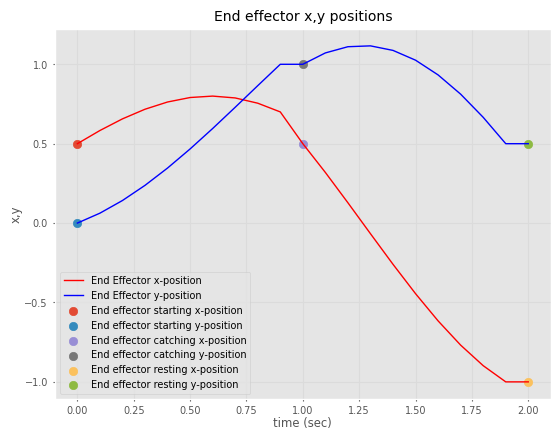

In [10]:
t = np.arange(0,2.1,0.1)
plt.plot(t, ee[:,0], linewidth = 1, color ='r', label ='End Effector x-position')
plt.plot(t, ee[:,1], linewidth = 1, color ='b', label ='End Effector y-position')

plt.scatter(0, x0[0], label = 'End effector starting x-position') # At time t = 0
plt.scatter(0, x0[1], label = 'End effector starting y-position') # At time t = 0

plt.scatter(1, x1[0], label = 'End effector catching x-position') # At time t = 1
plt.scatter(1, x1[1], label = 'End effector catching y-position') # At time t = 1

plt.scatter(2, x3[0], label = 'End effector resting x-position') # At time t = 2
plt.scatter(2, x3[1], label = 'End effector resting y-position') # At time t = 2

plt.title("End effector x,y positions")
plt.xlabel("time (sec)")
plt.ylabel("x,y")
plt.legend()

#### Plot 2:  $\dot x$,  $\dot y$ end effector velocities 

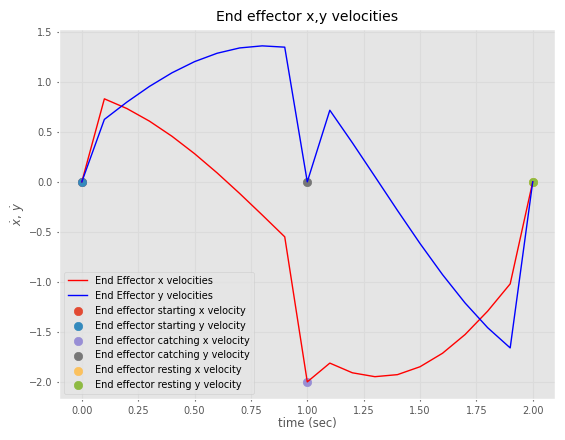

In [11]:
plt.plot(t, e_dot[:,0], linewidth = 1, color ='r', label ='End Effector x velocities')
plt.plot(t, e_dot[:,1], linewidth = 1, color ='b', label ='End Effector y velocities')

plt.scatter(0, 0, label = 'End effector starting x velocity') # At time t = 0
plt.scatter(0, 0, label = 'End effector starting y velocity') # At time t = 0

plt.scatter(1, b0_dot[0], label = 'End effector catching x velocity') # At time t = 1
plt.scatter(1, b0_dot[1], label = 'End effector catching y velocity') # At time t = 1

plt.scatter(2, 0, label = 'End effector resting x velocity') # At time t = 2
plt.scatter(2, 0, label = 'End effector resting y velocity') # At time t = 2

plt.title("End effector x,y velocities")
plt.xlabel("time (sec)")
plt.ylabel("$\dot x$, $\dot y$")
plt.legend()

#### Plot 3:  $\theta_1$,  $\theta_2$ joint angles 

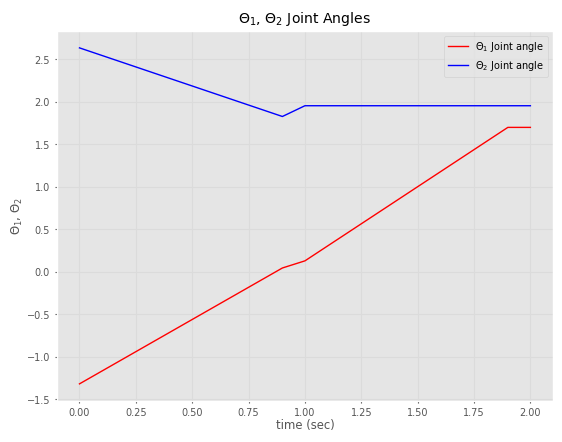

In [12]:
plt.plot(t, q[:,0], linewidth = 1, color ='r', label ='$\Theta_1$ Joint angle')
plt.plot(t, q[:,1], linewidth = 1, color ='b', label ='$\Theta_2$ Joint angle')

plt.title("$\Theta_1$, $\Theta_2$ Joint Angles")
plt.xlabel("time (sec)")
plt.ylabel("$\Theta_1$, $\Theta_2$")
plt.legend()

### Plot 4: $\dot \theta_1$, $\dot \theta_2$ joint angle velocities 

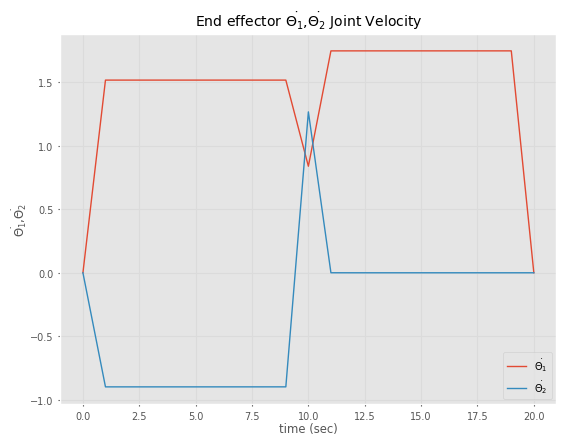

In [13]:
plt.plot(qd[:,0], linewidth = 1, label ='$\dot{\Theta_1}$')
plt.plot(qd[:,1], linewidth = 1, label ='$\dot{\Theta_2}$')

plt.title("End effector $\dot{\Theta_1}$,$\dot{\Theta_2}$ Joint Velocity")
plt.xlabel("time (sec)")
plt.ylabel("$\dot{\Theta_1}$,$\dot{\Theta_2}$")
plt.legend()

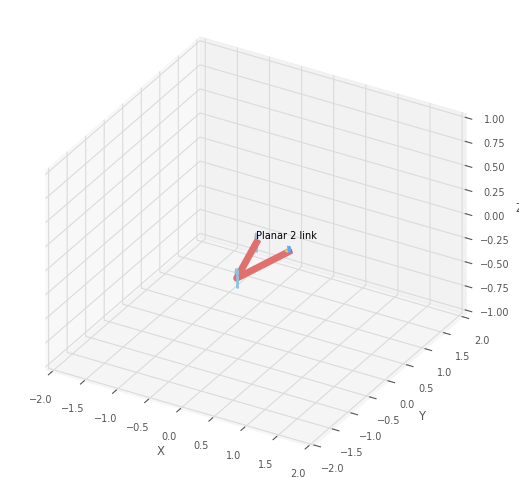

PyPlot3D backend, t = 1.0500000000000003, scene:
  Planar 2 link

<Figure size 640x480 with 0 Axes>

In [16]:
robot.plot(q,movie="3D_robot_catch.gif",backend='pyplot',limits=[-2,2,-2,2,-1,1])

In [15]:
ball_loc = []


for i in range(11):
    x = 2.5 - 0.1*(2)*i
    y = 1
    ball_loc.append([x, y])

ball_loc = np.array(ball_loc)

ball_loc = np.vstack((ball_loc,ee[11:,:]))

# # Plot the robot pose
for i in range(q.shape[0]):
    fig = plt . figure ()
    plot_fig = robot . plot ( q[i] , fig = fig, backend ='pyplot',limits=[-3,3,-3,3,-1,1])

    plt.scatter(ball_loc[i,0],ball_loc[i,1], color = 'blue', s = 64)

    # set plot view to the X-Y axis .
    plot_fig.ax.view_init (90 , -90 , 0)
    plt.savefig(f"{i}.png")
    plt.close(fig)
